# Extract Florida Voter Registration Data 1995-2016

In [1]:
import pandas as pd
import pdfplumber

## General procedure

In [2]:
pdf = pdfplumber.open("Records_raw/1995_YTDTotal.pdf")

In [3]:
p0 = pdf.pages[0]

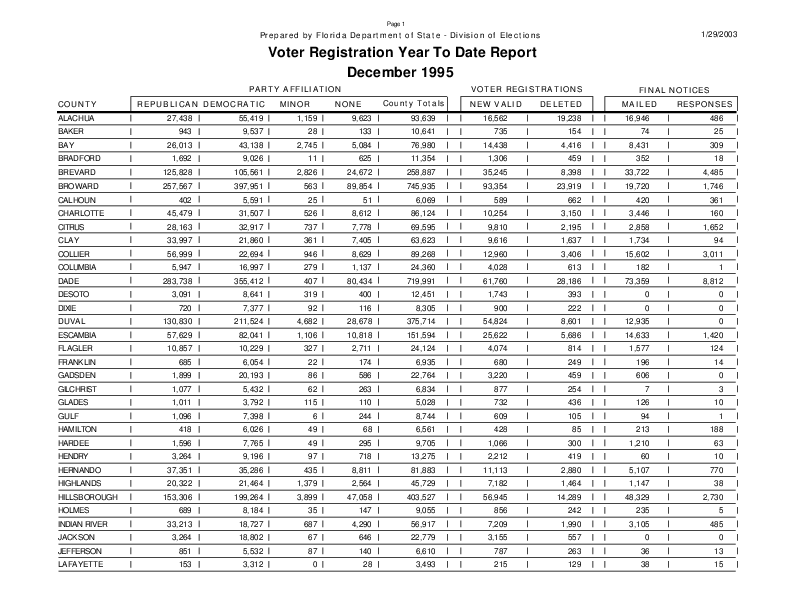

In [4]:
im = p0.to_image()
im

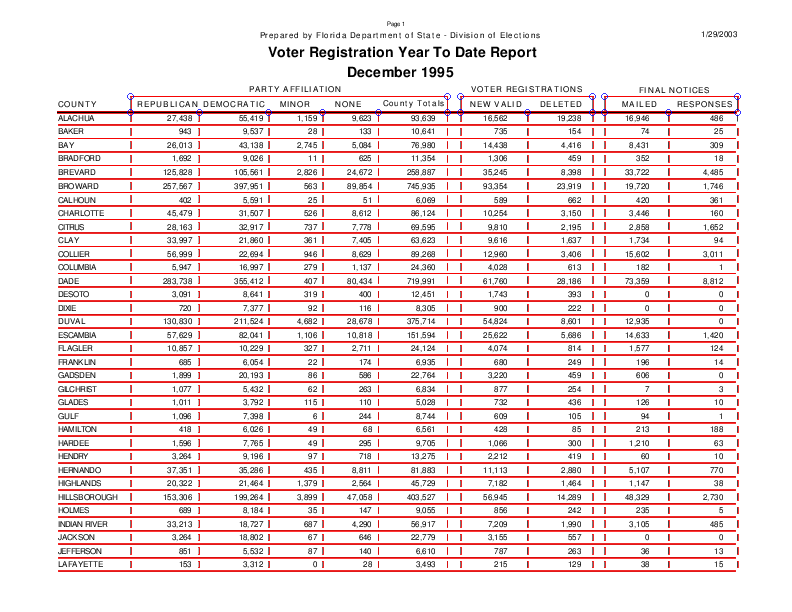

In [5]:
im.debug_tablefinder()

In [6]:
table_settings = {
    "vertical_strategy": "text",
    "horizontal_strategy": "lines"
}

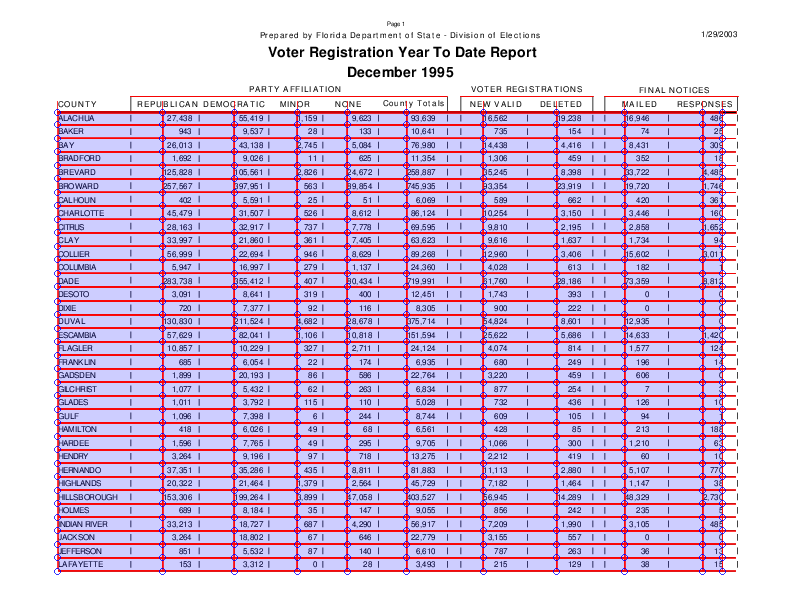

In [7]:
im.reset().debug_tablefinder(table_settings)

The `table_settings` parameters recognize the data components. The headers can be added separately.

In [8]:
table = p0.extract_table(table_settings)

In [9]:
table[0:2]

[['ALACHUA',
  '27,438',
  '55,419',
  '1,159',
  '9,623',
  '93,639',
  '16,562',
  '19,238',
  '16,946',
  '486'],
 ['BAKER', '943', '9,537', '28', '133', '10,641', '735', '154', '74', '25']]

In [10]:
cols = ["COUNTY", "REP", "DEM", "MIN", "NONE", "COUNTY_TOT", "NEW_VALID", "DEL", "MAILED", "RESPONSES"]

In [11]:
pd.DataFrame(table, columns=cols).head()

,COUNTY,REP,DEM,MIN,NONE,COUNTY_TOT,NEW_VALID,DEL,MAILED,RESPONSES
0,ALACHUA,"27,438","55,419","1,159","9,623","93,639","16,562","19,238","16,946",486
1,BAKER,943,"9,537",28,133,"10,641",735,154,74,25
2,BAY,"26,013","43,138","2,745","5,084","76,980","14,438","4,416","8,431",309
3,BRADFORD,"1,692","9,026",11,625,"11,354","1,306",459,352,18
4,BREVARD,"125,828","105,561","2,826","24,672","258,887","35,245","8,398","33,722","4,485"


Voila!

## Extract registration data and save to csv

Function to extract registration data from pdf as before

In [12]:
def extract_and_combine_tables(pdf_file, page_numbers, col_names, year):
    combined_table = pd.DataFrame(columns=col_names + ["YEAR"])

    with pdfplumber.open(pdf_file) as pdf:
        for page_number in page_numbers:
            page = pdf.pages[page_number - 1]
            table = page.extract_table(table_settings={"vertical_strategy":"text"})
            df = pd.DataFrame(table, columns = col_names)
            df["YEAR"] = year
            combined_table = pd.concat([combined_table, df], ignore_index=True)
            
    return combined_table

From 1995-2002 the format of the year-to-date report is virtually the same, therefore we can use the `extract_and_combine_tables` function as-is and save each report as a csv.

In [13]:
for record_year in range(1995,2003):
    df = extract_and_combine_tables(f"Records_raw/{record_year}_YTDTotal.pdf", [1,2], cols, year = record_year)
    df.to_csv(f"Records_clean/{record_year}_YTDTotal.csv", index=False)

From 2003-2009, the format changes a bit, causing the headers in the documents to be read as data. Add additional step to the loop to discard this row.

In [14]:
extract_and_combine_tables("Records_raw/2003_YTDTotal.pdf", [1], cols, year = 2003).head(3)

,COUNTY,REP,DEM,MIN,NONE,COUNTY_TOT,NEW_VALID,DEL,MAILED,RESPONSES,YEAR
0,None,BLICAN,DEMOCRATIC MI,NOR N,ONE Count,None,W VALID,None,MAILED RESP,ONSE,2003
1,ALACHUA,"32,866","61,162","2,826","19,585","116,439","10,475","20,657","16,969",747,2003
2,BAKER,"2,384","8,882",130,546,"11,942",815,"2,018",325,29,2003


In [15]:
for record_year in range(2003,2010):
    df = extract_and_combine_tables(f"Records_raw/{record_year}_YTDTotal.pdf", [1,2], cols, year = record_year)
    df = df.dropna(subset=['COUNTY'])
    df.to_csv(f"Records_clean/{record_year}_YTDTotal.csv", index=False)

For 2010 and 2011, the parameters don't recognize the `COUNTY` column. Since it is alphabetical we will add `COUNTY` from an earlier table.

In [16]:
pdf2 = pdfplumber.open("Records_raw/2010_YTDTotal.pdf")
im2 = pdf2.pages[0].to_image()

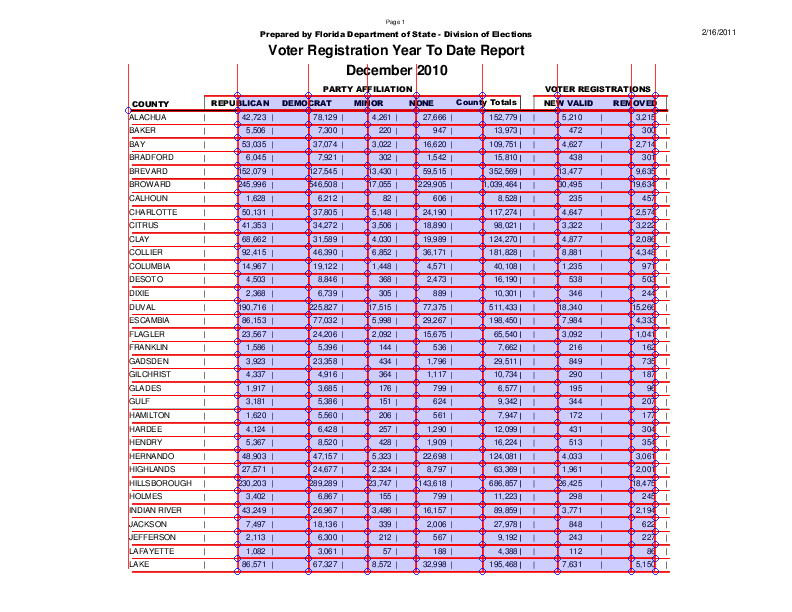

In [17]:
im2.debug_tablefinder(table_settings)

In [18]:
counties_alphabetical = extract_and_combine_tables("Records_raw/2002_YTDTotal.pdf", [1,2] , cols, 2002)['COUNTY']
counties_alphabetical

0        ALACHUA
1          BAKER
2            BAY
3       BRADFORD
4        BREVARD
         ...    
63       VOLUSIA
64       WAKULLA
65        WALTON
66    WASHINGTON
67        TOTALS
Name: COUNTY, Length: 68, dtype: object

In [19]:
for record_year in range(2010, 2012):
    combined_table = pd.DataFrame()
    with pdfplumber.open(f"Records_raw/{record_year}_YTDTotal.pdf") as pdf:
        for page in range(0,2):
            page = pdf.pages[page]
            table = page.extract_table(table_settings={"vertical_strategy":"text"})
            df = pd.DataFrame(table)
            df = df.iloc[1:, :2]
            combined_table = pd.concat([combined_table,df], ignore_index=True)
        combined_table.columns = ["REP", "DEM"]
        combined_table["COUNTY"] = counties_alphabetical
        combined_table["YEAR"] = record_year
        combined_table.to_csv(f"Records_clean/{record_year}_YTDTotal.csv", index=False)

From 2013-2016 the `COUNTY` column is recognized once again.

In [20]:
for record_year in range(2012,2017):
    combined_table = pd.DataFrame()
    with pdfplumber.open(f"Records_raw/{record_year}_YTDTotal.pdf") as pdf:
        for page in range(0,3):
            page = pdf.pages[page]
            table = page.extract_table(table_settings={"vertical_strategy":"text"})
            df = pd.DataFrame(table)
            df = df.iloc[1:, :3]
            combined_table = pd.concat([combined_table, df], ignore_index=True)
        combined_table.columns = ['COUNTY', 'REP', 'DEM']
        combined_table['YEAR'] = record_year
        combined_table.to_csv(f"Records_clean/{record_year}_YTDTotal.csv", index=False)

## Final thoughts

Pulling data from pdf's is annoying.